In [1]:
# produces unique combination of two lists
# using zip() and product() of itertools
#From https://www.geeksforgeeks.org/python-program-to-get-all-unique-combinations-of-two-lists/
def UniqueComboGenerator(list_1, list_2):
    # create empty list to store the
    # combinations
    unique_combinations = []
  
    # Getting all permutations of list_1 
    # with length of list_2
    permut = itertools.permutations(list_1, len(list_2))
  
    # zip() is called to pair each permutation
    # and shorter list element into combination
    for comb in permut:
        zipped = zip(comb, list_2)
        unique_combinations.append(list(zipped))
    
    unique_combinations = list(set(list(chain.from_iterable(unique_combinations))))
    return unique_combinations

In [2]:
#Removes all elements in list b from list a
def modification(a,b):
    c = a[:]
    for x in b:
        try:
            c.remove(x)
        except ValueError:
            pass
    return c

Welcome to JupyROOT 6.22/06
at for loop
Processed 0  /  61540413
Processed 10000  /  61540413
Processed 20000  /  61540413
Processed 30000  /  61540413
Processed 40000  /  61540413
Processed 50000  /  61540413
Processed 60000  /  61540413
Processed 70000  /  61540413
Processed 80000  /  61540413
Processed 90000  /  61540413
Processed 100000  /  61540413
Processed 110000  /  61540413
Processed 120000  /  61540413
Processed 130000  /  61540413
Processed 140000  /  61540413
Processed 150000  /  61540413
Processed 160000  /  61540413
Processed 170000  /  61540413
Processed 180000  /  61540413
Processed 190000  /  61540413
Processed 200000  /  61540413
Processed 210000  /  61540413
Processed 220000  /  61540413
Processed 230000  /  61540413
Processed 240000  /  61540413
Processed 250000  /  61540413
Processed 260000  /  61540413
Processed 270000  /  61540413
Processed 280000  /  61540413
Processed 290000  /  61540413


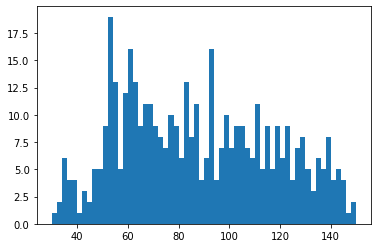

498


In [3]:
######################################################
#
#  June 2020
#
#  Script to read the Open Data parked dimuon sample
#  and produce a "data" object with the 4-vector
#  that is saved in a pickle file. 
#
#  Julie Hogan, j-hogan@bethel.edu
#
######################################################

import os,sys
from array import array
import pickle
import math
import numpy as np
import itertools
from itertools import permutations 
from itertools import combinations
from itertools import chain
import matplotlib.pyplot as plt
from numpy import linspace

## You will need ROOT to read the Open Data file
## Information at: https://root.cern.ch/  and http://opendata.cern.ch/docs/cms-getting-started-2011
from ROOT import TFile, TLorentzVector, TH1D, TCanvas

## Information at: http://opendata.cern.ch/record/12341,   DOI:10.7483/OPENDATA.CMS.LVG5.QT81
## You can also DOWNLOAD the ROOT file from that webpage and open the local version!
NanoMuons = TFile.Open("root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root")

## Histogram for testing -- currently set to show Upsilon mesons
## Example resonance ranges: 2.8 -- 3.5 GeV (J/Psi meson), 8 -- 12 GeV (Upsilon meson), 30 -- 150 GeV (Z boson)
hist = TH1D("hist",";dimuon mass (GeV)",40,30,150)

## Read the TTree object from the file
t = NanoMuons.Get("Events")

#events that fulfill requriemetns
hits = 0

## Initializing 4 Tlorentz Vectors
PosMuon1 = TLorentzVector()
PosMuon2 = TLorentzVector()
NegMuon1 = TLorentzVector()
NegMuon2 = TLorentzVector()

#A list of candidate Z boson masses
masses = []

data = []
isaved = 0
textfile = open("DoubleMuParked_100k.txt", "w")

xrange = range
## Loop over the events in the TTree

print('at for loop')
for ievent in xrange(t.GetEntries()):

    ## Cap the number of events in your output (smaller file sizes! 100k is enough for the exercise)
    if isaved >= 300000: continue

    if ievent % 10000 == 0: print('Processed',ievent,' / ',t.GetEntries())

    ## This line grabs one event's specific information
    t.GetEntry(ievent)

    #Skipping all events not equal to 4 muons
    if t.nMuon != 4:
        isaved += 1
        continue
        
        
    #Filtering out events that have less than two positives or less than two negatives
    negArray = np.array([])
    posArray = np.array([])
    for imu in range(t.nMuon):
        if t.Muon_charge[imu] < 0:
            negArray = np.append(negArray, imu)
        else:
            posArray = np.append(posArray, imu)
    if posArray.size < 2 or negArray.size < 2:
        isaved +=1 
        continue
        
    #Number entries that are used to fill in TLVs so that there are two positive charged muons and two negatives
    pos1 = int(posArray[0])
    pos2 = int(posArray[1])
    neg1 = int(negArray[0])
    neg2 = int(negArray[1])
    #TODO check that they are 1,2,3,4
    
    #Filling the 4TLVs. Numbers are hardcoded in, this is subject to change
    PosMuon1.SetPtEtaPhiM(t.Muon_pt[pos1],t.Muon_eta[pos1],t.Muon_phi[pos1],t.Muon_mass[pos1])
    PosMuon2.SetPtEtaPhiM(t.Muon_pt[pos2],t.Muon_eta[pos2],t.Muon_phi[pos2],t.Muon_mass[pos2])
    NegMuon1.SetPtEtaPhiM(t.Muon_pt[neg1],t.Muon_eta[neg1],t.Muon_phi[neg1],t.Muon_mass[neg1])
    NegMuon2.SetPtEtaPhiM(t.Muon_pt[neg2],t.Muon_eta[neg2],t.Muon_phi[neg2],t.Muon_mass[neg2])
     
    #A list of the four muons, subject to change if more than 4 muon events to be included
    MuonList = [PosMuon1, PosMuon2, NegMuon1, NegMuon2]
    
    #Amount of muons that pass the distance between them requriements
    accepetableDistanceCount = 0
    
    #Checking to see how many muons are within .02 of eachother within a given event
    MuonCombinations = list(combinations(MuonList, 2))    
    for MuonPair in MuonCombinations:
        if MuonPair[0].DeltaR(MuonPair[1]) > .02:
            accepetableDistanceCount += 1
    
    #At least one muon pair is within .02 of eachother so skip event
    if accepetableDistanceCount < len(MuonCombinations):
        isaved += 1
        continue
    
    #The amount of muons that have a momentum of ten to twenty respectively
    PtTenCount = 0
    PtTwentyCount = 0
    
    #Counting how many muons momemntum are over 10 and 20 respectively
    for Muon in MuonList:
        if Muon.Pt() > 10:
            PtTenCount += 1
        if Muon.Pt() > 20:
            PtTwentyCount += 1
            
    #At least two muons momemtum's have to be over 10 and one has to be over 20 or else event is discarded        
    if PtTenCount < 2 or PtTwentyCount < 1:
        isaved += 1
        continue
        
    
    #defining two separate lists for positive and negative muons
    PosMuonList = [PosMuon1, PosMuon2]
    NegMuonList = [NegMuon1, NegMuon2]

    
    acceptableMassCount = 0
    Z = TLorentzVector()
    Z1 = TLorentzVector()
    Z1Pair = []
    H = 0
    
    # Making a list containing all unique combos of positive and negative muons
    PlusMinusPairs = UniqueComboGenerator(PosMuonList, NegMuonList)
    
    #Checking to see what muon pair mass is closest to 90 if any, all pairs must be over 4
    for MuonPair in PlusMinusPairs:
        Z = MuonPair[0] + MuonPair[1] 
        if Z.M() > 4:
            acceptableMassCount += 1
        if Z.M() > 12 and Z.M() < 120 and (abs(90-Z.M())) < (abs(90-Z1.M())):
            Z1 = Z
            Z1Pair = MuonPair
           
        
    #all four muons pairs must have M > 4 and Z1.M() != 0  
    if acceptableMassCount < 4 or Z1.M() == 0:
        isaved += 1
        continue
    
    #Finding intitial Z2 pairing and mass
    Z2Pair = modification(MuonList, Z1Pair)
    Z2 = Z2Pair[0] + Z2Pair[1]
    
    #If Z2 is in 12-120 range keep event, if Z2 is less than 12 discard, else check flipped
    if(Z2.M() > 12 and Z2.M() < 120):
        H = Z1 + Z2
    elif Z2.M() < 12:
        isaved += 1
        continue
    else:   
        #If this point is reached, the event may still be salvageable by flipping OS pairs
        #Repeating same prcoess of finding closest pair to mass of 90 but flipped
        #Removing the first attempt OS pairs from all PlusMinusPairs leaving only the flipped pairs
        PlusMinusPairs = modification(PlusMinusPairs, [Z1Pair])
        PlusMinusPairs = modification(PlusMinusPairs, [Z2Pair])
        
        #This line is here just in case the Z2 pair tuple accidently got reversed
        PlusMinusPairs = modification(PlusMinusPairs, [(Z2Pair[1],Z2Pair[0])])
          

        Z = TLorentzVector()
        Z1 = TLorentzVector()
        Z1Pair = []
        for MuonPair in PlusMinusPairs:
            Z = MuonPair[0] + MuonPair[1] 
            if Z.M() > 12 and Z.M() < 120 and (abs(90-Z.M())) < (abs(90-Z1.M())):
                Z1 = Z
                Z1Pair = MuonPair
        Z2Pair = modification(MuonList, Z1Pair)
        Z2 = Z2Pair[0] + Z2Pair[1]
        if(Z2.M() > 12 and Z2.M() < 120):
            H = Z1 + Z2
            
    
    #Neither the original muon pair or flipped pair meet the requirements if H == 0, skip event
    if H == 0:
        isaved += 1
        continue
    
    #Filling the mass array      
    hits += 1
    isaved += 1
    masses.append(H.M())
    
#Making the histogram
edges = linspace(30,150,61).tolist()
counts, edges, plot = plt.hist(masses,edges)
plt.show()

print(hits)

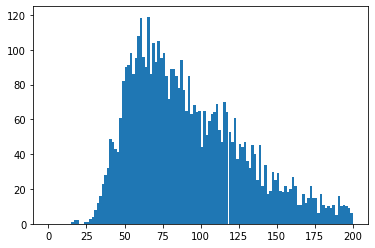

In [9]:
#Making the histogram
edges = linspace(0,200,121).tolist()
counts, edges, plot = plt.hist(masses,edges)
plt.show()